## 为什么是要除以一个d_k(scaled)?
- 本质是为了稳定梯度流
- 因为softmax在

### 首先对于两个独立的标准正太分布q, k 它的均值为0, 方差为1

In [29]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
q  = torch.randn(1, 5, 200)
k = torch.randn(1, 5, 200)
print('均值', torch.mean(q))
print('方差', torch.var(q))

均值 tensor(-0.0349)
方差 tensor(1.0463)


### 点积之后的方差会变大

In [30]:
logits = torch.matmul(q, k.transpose(1, 2))
logits.var()

tensor(158.0351)

In [270]:
torch.matmul(q, q.transpose(1, 2)).var()

tensor(7613.2290)

### 除以 $\sqrt{d_k}$ 方差就会变小, 进而不会出现非常大的值

In [31]:
scaled = logits / torch.sqrt(torch.tensor(200))

In [32]:
scaled.var()

tensor(0.7902)

### 因为softmax在输入数量级比较大的时候会把全部概率分配给最大的值
- 假设输入为$x = [a, a, 2a]$

In [43]:
x = torch.linspace(0, 100, 100)
f = lambda x: torch.exp(x * 2) / (torch.exp(x) + torch.exp(x) + torch.exp(x * 2))
y = [f(x_i) for x_i in x]

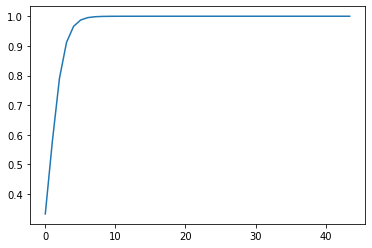

In [45]:
plt.plot(x, y)   # 可以看到softmax将所有概率给了2a

### 也就是说softmax在输入数量级比较大的时候, 梯度会很小(消失)

In [254]:
#对比实验
class MulAttention(torch.nn.Module):
    def __init__(self, scale):
        super().__init__()
        self.scale =scale
    def forward(self, q, k, v):
        logits = torch.matmul(q, k.transpose(-2, -1)) / self.scale
        scores = F.softmax(logits, dim=-1)
        output = torch.matmul(scores, v)
        return output
        

class AttentionModel(torch.nn.Module):
    def __init__(self, dim, scale):
        super().__init__()
        self.dim = dim
        self.scale = torch.tensor(scale)
        self.attentions = torch.nn.ModuleList([MulAttention(self.scale) for _ in range(12)])
        self.classifier = torch.nn.Linear(dim, 10)

    def forward(self, x, q, k, v):
        for attn in self.attentions:
            x = attn(x)
        print(x.shape)
        logits = self.classifier(x)
        return logits

In [279]:
x1 = torch.randn(10, 100, requires_grad=True)
x2 = torch.randn(10, 10000, requires_grad=True)

In [285]:
model = AttentionModel(dim=100, scale=1)

In [286]:
y = model(x1)
loss = torch.nn.CrossEntropyLoss()(y, torch.tensor([0,1,2,3,3,4,4,5,2,4]))
loss.backward()

torch.Size([10, 100])


In [287]:
[torch.max(grad) for grad in x2.grad]

[tensor(0.0023),
 tensor(0.0023),
 tensor(0.0024),
 tensor(0.0020),
 tensor(0.0023),
 tensor(0.0023),
 tensor(0.0025),
 tensor(0.0022),
 tensor(0.0024),
 tensor(0.0026)]

In [283]:
model = AttentionModel(dim=10000, scale=1)

In [284]:
y = model(x2)
loss = torch.nn.CrossEntropyLoss()(y, torch.tensor([0,1,2,3,3,4,4,5,2,4]))
loss.backward()

torch.Size([10, 10000])


In [278]:
[torch.max(torch.abs(grad)) for grad in x2.grad]

[tensor(0.0044),
 tensor(0.0054),
 tensor(0.0041),
 tensor(0.0037),
 tensor(0.0043),
 tensor(0.0043),
 tensor(0.0041),
 tensor(0.0043),
 tensor(0.0046),
 tensor(0.0046)]

In [290]:
from scipy.special import softmax
import numpy as np

def test_gradient(dim, time_steps=50, scale=1.0):
    # Assume components of the query and keys are drawn from N(0, 1) independently
    q = np.random.randn(dim)
    ks = np.random.randn(time_steps, dim)
    x = np.sum(q * ks, axis=1) / scale  # x.shape = (time_steps,) 
    y = softmax(x)
    grad = np.diag(y) - np.outer(y, y)
    return np.max(np.abs(grad))  # the maximum component of gradients

NUMBER_OF_EXPERIMENTS = 5
# results of 5 random runs without scaling
print([test_gradient(100) for _ in range(NUMBER_OF_EXPERIMENTS)])
print([test_gradient(1000) for _ in range(NUMBER_OF_EXPERIMENTS)])

# results of 5 random runs with scaling
print([test_gradient(100, scale=np.sqrt(100)) for _ in range(NUMBER_OF_EXPERIMENTS)])
print([test_gradient(1000, scale=np.sqrt(1000)) for _ in range(NUMBER_OF_EXPERIMENTS)])

[0.16563217565858068, 0.026832742169559998, 0.03760569444895312, 0.24645576721826684, 0.24687804603104316]
[0.00011828531697377631, 0.1822529814293652, 5.457536644826178e-10, 1.3216094885137863e-12, 9.595268468665097e-09]
[0.07254351566421828, 0.08783516871558304, 0.13096732398840355, 0.11687844761880893, 0.07965179714885315]
[0.1135116952703806, 0.13463629554899875, 0.23014945460707764, 0.09522641492313243, 0.07154209877134614]
